In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm, linear_model, metrics
import numpy as np
import string
import random
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem.porter import *
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        try:
            yield eval(l)
        except:
            continue

In [4]:
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r

In [5]:
dataset = []
for d in readGz("renttherunway_final_data.json.gz"):
    dataset.append(d)


In [6]:
len(dataset)

192462

In [7]:
def heightConversion(h):
    ft, inch = h.split('\' ')
    ft = int(ft)
    inch = int(inch.replace('\"', ''))
    return ft * 12 + inch

In [8]:
new_dataset = []
punctuation = set(string.punctuation)

for d in dataset:
    feature_needed = ['weight', 'height', 'fit', 'size', 'body type', 'review_text', 'review_summary', 'rating']
    keys = list(d.keys())
    if all([i in keys for i in feature_needed]):
        d['weight'] = int(d['weight'].replace("lbs", ""))
        d['height'] = heightConversion(d['height'])
        new_dataset.append(d)

In [9]:
len(new_dataset)

153441

In [10]:
y1 = [d['fit'] for d in new_dataset]

In [11]:
dataTrain1, data_vt1, ytrain1, y_vt1 = train_test_split(new_dataset, y1, test_size=0.3, random_state=42)
dataValid1, dataTest1, yvalid1, ytest1 = train_test_split(data_vt1, y_vt1, test_size=0.5, random_state=42)
len(dataTrain1), len(dataValid1), len(dataTest1)

(107408, 23016, 23017)

In [12]:
Xtrain1 = [[1, d['weight'], d['height'], d['size']] for d in dataTrain1]
Xvalid1 = [[1, d['weight'], d['height'], d['size']] for d in dataValid1]
Xtest1 = [[1, d['weight'], d['height'], d['size']] for d in dataTest1]

In [13]:
# Baseline Model - using only weight, height and size
mods = {}
F1Valid = {}
F1Train = {}
F1scores = []
bestModel = None
bestVal = None
bestI = None
for i in range(2,25):
    baselineMod = DecisionTreeClassifier(max_depth=i)
    baselineMod.fit(Xtrain1,ytrain1)
    mods[i] = baselineMod
    blPred = baselineMod.predict(Xvalid1)
    blF1 = metrics.f1_score(yvalid1, blPred, average='weighted',zero_division=0)
    F1Valid[i] = blF1
    blPredTr = baselineMod.predict(Xtrain1)
    blF1Tr = metrics.f1_score(ytrain1, blPredTr, average='weighted',zero_division=0)
    F1Train[i] = blF1Tr
    F1scores.append(blF1)
    print("C = {}, F_1 score is {}.".format(str(i), str(blF1)))
    if bestVal == None or blF1 > bestVal:
        bestVal = blF1
        bestModel = baselineMod
        bestI = i

C = 2, F_1 score is 0.6211854113684363.
C = 3, F_1 score is 0.6211854113684363.
C = 4, F_1 score is 0.6211854113684363.
C = 5, F_1 score is 0.6211854113684363.
C = 6, F_1 score is 0.6211797652217251.
C = 7, F_1 score is 0.6212300680822704.
C = 8, F_1 score is 0.6235943992050079.
C = 9, F_1 score is 0.6225982884482651.
C = 10, F_1 score is 0.6237080607084854.
C = 11, F_1 score is 0.6244724376952148.
C = 12, F_1 score is 0.624936117100185.
C = 13, F_1 score is 0.6253190826958486.
C = 14, F_1 score is 0.6253387606859218.
C = 15, F_1 score is 0.6262477492677637.
C = 16, F_1 score is 0.6271113544593223.
C = 17, F_1 score is 0.6274867388206713.
C = 18, F_1 score is 0.6280038012997389.
C = 19, F_1 score is 0.6277348176005503.
C = 20, F_1 score is 0.6279159894422742.
C = 21, F_1 score is 0.6277859271943412.
C = 22, F_1 score is 0.6277754193678552.
C = 23, F_1 score is 0.6278222637031495.
C = 24, F_1 score is 0.6279198168021551.


In [14]:
bestI, bestVal

(18, 0.6280038012997389)

In [15]:
predTest = bestModel.predict(Xtest1)
f1Test1 = metrics.f1_score(ytest1, predTest, average='weighted',zero_division=0)
f1Test1

0.6371671890654981

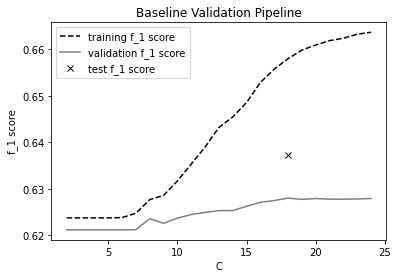

In [17]:
plt.xticks([])
plt.xlabel(r"C")
plt.ylabel(r"f_1 score")
plt.title(r"Baseline Validation Pipeline")
plt.xscale('linear')
plt.plot(range(2,25), list(F1Train.values()), color='k', linestyle='--', label='training f_1 score')
plt.plot(range(2,25), list(F1Valid.values()), color='grey',zorder=4,label="validation f_1 score")
plt.plot([bestI], [f1Test1], linestyle='', marker='x', color='k', label="test f_1 score")
plt.legend(loc='best')
plt.show()

In [18]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
sw = stopwords.words("English")
for d in dataTrain1:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        wordCount[w] += 1

len(wordCount)

28832

In [21]:
counts = [(wordCount[w],w) for w in wordCount if w not in sw]
counts.sort()
counts.reverse()
len(counts)

28718

In [22]:
words = [x[1] for x in counts[:5000]]

In [23]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [43]:
def feature2(d): 
    feat = [0]*len(words)
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        if w in words:
            feat[wordId[w]] += 1
    return [1] + [d['weight'], d['height'], d['size']] + feat

In [46]:
Xtrain2 = [feature2(d) for d in dataTrain1]

In [45]:
Xvalid2 = [feature2(d) for d in dataValid1]

In [44]:
Xtest2 = [feature2(d) for d in dataTest1]

In [47]:
# Track the model which works best on the validation set
bestModel = None
bestVal = None
bestC = None
models = dict()
f1Valid = dict()
f1Train = dict()

for c in range(2,25):
    model = DecisionTreeClassifier(max_depth=c)
    model.fit(Xtrain2, ytrain1)
    models[c] = model
    predictValid = model.predict(Xvalid2)
    f1V = metrics.f1_score(yvalid1, predictValid, average='weighted', zero_division=0)
    f1Valid[c] = f1V
    predictTrain = model.predict(Xtrain2)
    f1T = metrics.f1_score(ytrain1, predictTrain, average='weighted', zero_division=0)
    f1Train[c] = f1T
    print("C = " + str(c) + ", validation F_1 score = " + str(f1V))
    if bestVal == None or f1V > bestVal:
        bestVal = f1V
        bestModel = model
        bestC = c


C = 2, validation F_1 score = 0.6664634686055476
C = 3, validation F_1 score = 0.7181325149323153
C = 4, validation F_1 score = 0.7112772402134859
C = 5, validation F_1 score = 0.7365494237291323
C = 6, validation F_1 score = 0.744739286918367
C = 7, validation F_1 score = 0.7465805835820297
C = 8, validation F_1 score = 0.7524408011462002
C = 9, validation F_1 score = 0.7529425721156253
C = 10, validation F_1 score = 0.7521087239105206
C = 11, validation F_1 score = 0.754105886584086
C = 12, validation F_1 score = 0.755512629011757
C = 13, validation F_1 score = 0.7543200239772953
C = 14, validation F_1 score = 0.7547309246326788
C = 15, validation F_1 score = 0.7543284529058123
C = 16, validation F_1 score = 0.7533132404419972
C = 17, validation F_1 score = 0.7530132109086656
C = 18, validation F_1 score = 0.7516317844408937
C = 19, validation F_1 score = 0.7495138111819362
C = 20, validation F_1 score = 0.7481472851197275
C = 21, validation F_1 score = 0.7488419032132253
C = 22, val

In [48]:
bestC, bestVal

(12, 0.755512629011757)

In [49]:
predictTest = bestModel.predict(Xtest2)
f1Test = metrics.f1_score(ytest1, predictTest, average='weighted',zero_division=0)
f1Test

0.760285085531351

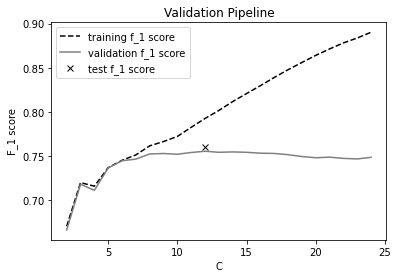

In [50]:
plt.xticks([])
plt.xlabel(r"C")
plt.ylabel(r"F_1 score")
plt.title(r"Validation Pipeline")
plt.xscale('linear')
plt.plot(range(2,25), list(f1Train.values()), color='k', linestyle='--', label='training f_1 score')
plt.plot(range(2,25), list(f1Valid.values()), color='grey',zorder=4,label="validation f_1 score")
plt.plot([bestC], [f1Test], linestyle='', marker='x', color='k', label="test f_1 score")
plt.legend(loc='best')
plt.show()